# Horses vs humans

In [1]:
import os 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                               include_top = False, 
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.999):
            print('\nReached 99.9% accuracy so canceling training')
            self.model.stop_traning = True

In [20]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation= 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [6]:
local_zip = 'tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/training')
zip_ref.close()

local_zip = 'tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation')
zip_ref.close()

In [7]:
train_path = 'tmp/training/'
validation_path = 'tmp/validation/'

train_horses_dir = os.path.join(train_path, 'horses')
train_humans_dir = os.path.join(train_path, 'humans')
validation_horses_dir = os.path.join(validation_path, 'horses')
validation_humans_dir = os.path.join(validation_path, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)



In [21]:
print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
528
128
128


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size=20,
                                                   class_mode = 'binary',
                                                   target_size = (150,150))
validation_generator = test_datagen.flow_from_directory(validation_path,
                                                   batch_size=20,
                                                   class_mode = 'binary',
                                                   target_size = (150,150))

Found 1029 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [23]:
callbacks = myCallback()

history = model.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 5,
            validation_steps = 10,
            verbose = 1,
            callbacks=[callbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 10 steps
Epoch 1/5
50/50 [==============================] - 51s 1s/step - loss: 0.2888 - acc: 0.8736 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 2/5
50/50 [==============================] - 50s 995ms/step - loss: 0.1196 - acc: 0.9535 - val_loss: 1.7595e-04 - val_acc: 1.0000
Epoch 3/5
50/50 [==============================] - 48s 966ms/step - loss: 0.0828 - acc: 0.9656 - val_loss: 0.0128 - val_acc: 0.9950
Epoch 4/5
50/50 [==============================] - 51s 1s/step - loss: 0.0740 - acc: 0.9687 - val_loss: 0.0056 - val_acc: 0.9950
Epoch 5/5
50/50 [==============================] - 52s 1s/step - loss: 0.0418 - acc: 0.9848 - val_loss: 0.0013 - val_acc: 1.0000


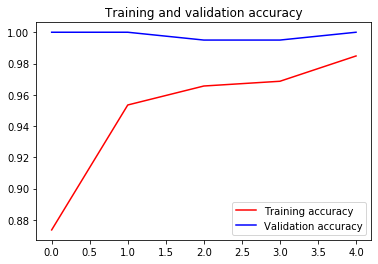

<Figure size 432x288 with 0 Axes>

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [42]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________